# $$\textbf{Application on genotoxin dataset} $$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os 

import sys
sys.path.insert(0, 'utils/')

import sklearn
from scipy import interpolate
import pickle
import seaborn as sns

from factorizer import *
import ssd
import pandas as pd
import scipy
from scipy import cluster as sc

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
fig_path = "./figures/genotoxin/"
#create directory if it does not exist
try:
    os.mkdir(fig_path)
except:
    print(f"already have directory {fig_path}")

already have directory ./figures/genotoxin/


In [5]:
def plot_M_from_M(M, l_names, two_line = True, labelsize = 15):
        
        if two_line: numl = int(M.shape[1]/2)
        else: numl = M.shape[1]


        fig,axis = plt.subplots(1,1,figsize = (24,6))
        im = axis.imshow(np.abs(M[:,:numl]),cmap = "Greys", vmin = 0, vmax = .7*np.max(np.abs(M)))
        axis.tick_params(labelsize = labelsize)
        axis.set_xticks(np.arange(numl))
        axis.set_yticks(np.arange(M.shape[0]))
        axis.set_xticklabels(l_names[:numl], rotation=90)
        axis.set_xlabel("Loci",fontsize = 22)
        axis.set_ylabel("Modules",fontsize = 22)
        for sp in ['top','bottom','left','right']:
            axis.spines[sp].set_linewidth(1.25)
        plt.show()
        
        if two_line:  
            fig,axis = plt.subplots(1,1,figsize = (24,6))
            im = axis.imshow(np.abs(M[:,numl:]),cmap = "Greys", vmin = 0, vmax = .7*np.max(np.abs(M)))
            axis.tick_params(labelsize = labelsize)
            axis.set_xticks(np.arange(len(l_names[numl:])))
            axis.set_yticks(np.arange(M.shape[0]))
            axis.set_xticklabels(l_names[numl:], rotation=90)
            axis.set_xlabel("Loci",fontsize = 22)
            axis.set_ylabel("Modules",fontsize = 22)
            for sp in ['top','bottom','left','right']:
                axis.spines[sp].set_linewidth(1.25)
            plt.show()
    

In [6]:
def plot_W_from_W(W, e_names, labelsize=15, pp=95, max_rows=100, T=None):
    print("W: plot\n")
   
    if T is not None and T.shape[0] == W.shape[0]:
        W = deepcopy(T)
    nume = min(W.shape[0], max_rows)
    sort_c = np.argsort(-np.sum(W**4, axis=0))
    fig, axis = plt.subplots(1, 1, figsize=(14, 5))
    mm = np.percentile(W, pp)
    im = axis.imshow(W[:nume, :].T, cmap="RdBu", vmin=-mm, vmax=mm)
    cb = fig.colorbar(mappable=im)
    cb.ax.tick_params(labelsize=16)
    axis.set_xticks(np.arange(nume))
    axis.tick_params(labelsize=labelsize)
    axis.set_xticklabels(e_names, rotation=90)
    axis.set_xlabel("Environments", fontsize=22)
    axis.set_ylabel("Modules", fontsize=22)
    for sp in ["top", "bottom", "left", "right"]:
        axis.spines[sp].set_linewidth(1.25)
    fig.tight_layout()
    plt.show()

In [7]:
def plot_module_by_loci_for_pw(M, pathways, pathway_names, normalize = False):
    if normalize: M = np.abs(M)/np.sum(np.abs(M), axis = 0) # each loci is a distribution over modules
    for p,name in enumerate(pathway_names):
        plt.imshow(np.abs(M[:,pathways[...,p]==1]), cmap = "Greys")
        plt.xlabel("loci")
        plt.ylabel("modules")
        plt.colorbar()
        plt.title(name)
        plt.show()

In [8]:
# returns permutation of M_pred to closest match M_true
def perm_to_match(M_pred,M_true):

    def _remove(p1, p2, the_list):
        return [_ for _ in the_list if _[0]!=p1 and _[1]!=p2]

    K = M_pred.shape[0]
    if K != M_true.shape[0]:
        #could modify code so we don't need this; but if we know the true K, will we run it with different values
        raise ValueError("need same shape K") 
    dots_svd = np.abs(np.einsum('ij,kj->ik', M_pred, M_true))
    pairs = [(a,b) for a in range(K) for b in range(K)]
    plist = [pairs[_] for _ in np.argsort(dots_svd, axis = None)[::-1]]
    perm = []
    while len(plist)>0:
        perm.append(plist[0])
        plist = _remove(perm[-1][0],perm[-1][1], plist)
    new_pos = [0 for _ in range(K)]
    for pair in perm:
        new_pos[pair[1]]=pair[0]

    return M_pred[new_pos,:]

def perm_and_plot(M_pred, M_true, M_pred_name=None, M_true_name=None, perm = True):
    if perm: M_perm = perm_to_match(M_pred, M_true)
    else: M_perm = M_pred
    def _norm(M):
        return (M.T/np.sqrt(np.square(M).sum(-1))).T
    M_perm = _norm(M_perm)
    M_true = _norm(M_true)
    plt.imshow(np.abs(M_perm @ M_true.T))
    if M_pred_name is not None:
        plt.ylabel(M_pred_name)
    if M_true_name is not None:
        plt.ylabel(M_true_name)
    plt.colorbar()
    plt.show()
    

In [9]:
def display_pathways_of_modules(M, pathways, pathway_names, binary = False, include_NA = False):
    if not binary:
        pw_weights = np.abs(M)@pathways 
    if binary:
        pw_weights = (np.abs(M)>0)@pathways
    labelsize=16
    if not include_NA:
        pw_weights = pw_weights[...,:-1]
        pathway_names = pathway_names[:-1]
    fig,axis = plt.subplots(1,1,figsize = (5,5))
    mm = np.max(pw_weights)
    im = axis.imshow(pw_weights,cmap = "Greys", vmin=0 , vmax=mm)
    cb = fig.colorbar(mappable = im)
    cb.ax.tick_params(labelsize = labelsize)
    axis.set_xticks(np.arange(pw_weights.shape[1]))
    axis.set_yticks(np.arange(pw_weights.shape[0]))
    axis.tick_params(labelsize = labelsize)
    axis.set_xticklabels(pathway_names,rotation=90)
    axis.set_xlabel("Pathways",fontsize = labelsize)
    axis.set_ylabel("Modules",fontsize = labelsize)
    for sp in ['top','bottom','left','right']:
        axis.spines[sp].set_linewidth(1.25)
    fig.tight_layout()
    plt.show()
        

In [10]:
# will permute to match M2
def compare_pair_of_Ms(M1, M2, name_M1, name_M2, l_names, pathways, pathway_names):
    M1 = perm_to_match(M1, M2)
    print(name_M1)
    plot_M(M1, l_names)
    print(name_M2)
    plot_M(M2,l_names)
    print(f"modularity of {name_M1}: {em.compute_modularity_and_dropped_loci(M1)[0]:3f}")
    print(f"modularity of {name_M2}: {em.compute_modularity_and_dropped_loci(M2)[0]:3f}")
    print(f"grassman between {name_M1} and {name_M2}: {em.grassmann(M1, M2):.3f}")
    perm_and_plot(M1,M2, M_pred_name = name_M1, M_true_name = name_M2, perm=False)
    print(name_M1)
    display_pathways_of_modules(M1,pathways,pathway_names, binary = False)
    print(name_M2)
    display_pathways_of_modules(M2,pathways,pathway_names, binary = False)
    

In [11]:
od = pd.read_csv("data/genotoxic_input.tsv", sep = '\t') # downloaded from https://figshare.com/articles/dataset/Webster_Supplemental_Output/14963561
od = od.set_index("Treatment")
F = od.values
meta = pd.read_csv("data/genotoxic_gene_meta.tsv", sep = '\t') # downloaded from https://figshare.com/articles/dataset/Webster_Supplemental_Output/14963561

pathway_names = []
for q in meta["Literature_Pathway"]:
    if type(q)!=float:
        ps = q.split("; ")
        for p in ps:
            if p not in pathway_names: pathway_names.append(p)

pathway_d = {}
for n,p in enumerate(pathway_names):
    pathway_d[p]=[]
    for q in meta["Literature_Pathway"]:
        if type(q)!=float:
            ps = q.split("; ")
            if p in ps:
                pathway_d[p].append(1)
            else: 
                pathway_d[p].append(0)
        else: pathway_d[p].append(0)
pathway_d["NA"] = []
for q in meta["Literature_Pathway"]:
    if type(q)!=float:
        pathway_d["NA"].append(1)
    else: pathway_d["NA"].append(0)
pathway_names.append("NA")

pathways_df = pd.DataFrame.from_dict(pathway_d)
pathways = pathways_df.values
print(pathway_names)

['FORK QC', 'HR', 'FA/ICL repair', 'EJ', 'NER', 'MMR', 'RER', 'BER/SSBR', 'OTHER', 'NA']


In [12]:
for x in meta["Literature_Pathway"]:
    if ";" in str(x): print(x)

FA/ICL repair; HR
FA/ICL repair; HR
FA/ICL repair; HR
NER; FA/ICL repair
MMR; RER; HR
RER; BER/SSBR
HR; FA/ICL repair
BER/SSBR; EJ
FA/ICL repair; HR


## Modules found by Webster

In [13]:
oWdf = pd.read_csv("data/genotoxic_dictionary.tsv", sep = '\t') # downloaded from https://figshare.com/articles/dataset/Webster_Supplemental_Output/14963561
oWdf = oWdf.set_index("Treatment")
oW = oWdf.values
oW.shape

(31, 10)

In [14]:
oMdf = pd.read_csv("data/genotoxic_gene_loadings.tsv", sep = '\t') # downloaded from https://figshare.com/articles/dataset/Webster_Supplemental_Output/14963561
oMdf = oMdf.set_index("Gene")
oM = oMdf.values.T* np.sqrt(31) # undo normalization; confirmed with first author by email 2/2/22
oM.shape

(10, 304)

# load our results

In [15]:
lamb2_range = 10**(np.linspace(np.log10(1e-3),np.log10(1.5),25))
lamb1_range = 10**(np.linspace(np.log10(1e-4),np.log10(1e-2),25))
lamb1_fixed = [1e-4]
lamb2_fixed = [1e-3]
directory = "pickled_factorizers"
mode = "genotoxin"
print(mode)
fcts = pickle.load(open(f"{directory}/{mode}","rb"))

genotoxin


20


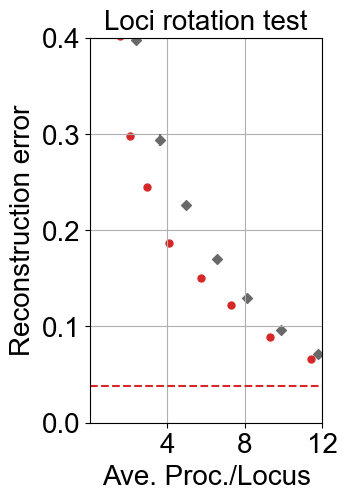

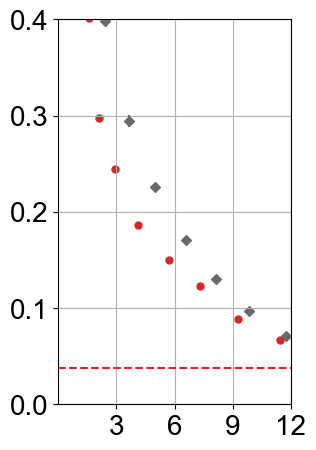

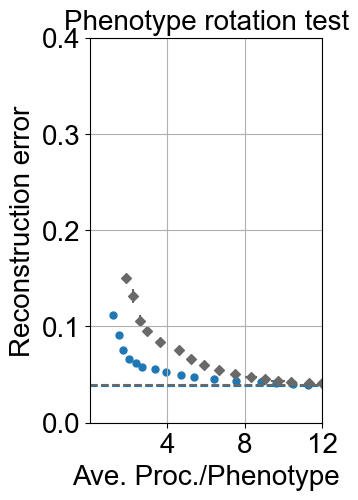

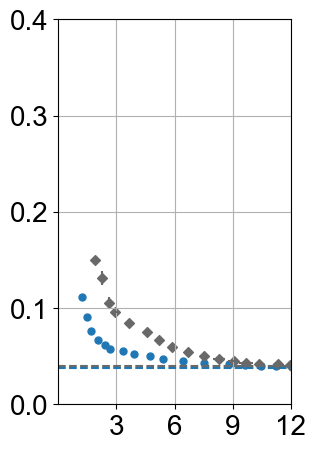

In [16]:
yrange = (0,.4)
xrange = (0,12)
figsize = (3,5)

name = mode
fct = fcts[(name ,None,None)]
K = fct.computed_params(printout = False)[0][1]
print(K)
fct_rots = [fcts[(name, None, i)] for i in [3,4,5]] 
rotate = "loci"
#plot_rotation_test(fct, fct_rot, K, lamb1_fixed, lamb2_range, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = fig_path + "Mrot_" + mode + ".pdf")
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_fixed, lamb2_range, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = None, figsize = figsize, xticks = [4,8,12], oc='tab:red', rotc='dimgrey', labels= True, legend = False)
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_fixed, lamb2_range, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.svg", figsize = figsize, xticks = [3,6,9,12], oc='tab:red', rotc='dimgrey', labels= False, legend = False)


fct_rots = [fcts[(name, i, None)] for i in [0,1,2]] 
rotate = "env"
#plot_rotation_test(fct, fct_rot, K, lamb1_range, lamb2_fixed, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name =  fig_path + "Wrot_" + mode + ".pdf")
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_range, lamb2_fixed, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = None, figsize = figsize, xticks = [4,8,12], oc='tab:blue', rotc='dimgrey', labels= True, legend = False)
plot_rotation_test_w_error(fct, fct_rots, K, lamb1_range, lamb2_fixed, xrange, yrange, rotate, fs = 20, svd_k=K, true_line = False, save_name = f"{fig_path}/{rotate}_rot_test.svg", figsize = figsize, xticks = [3,6,9,12], oc='tab:blue', rotc='dimgrey', labels= False, legend = False)


('reg', 20, (0.0015, 0.8155), (0, 0)) 2.013651877133106 6.774193548387097 10 0.33044144688339855
('reg', 20, (0.0056, 0.4433), (0, 0)) 3.2549668874172184 2.533333333333333 10 0.29506816233923455


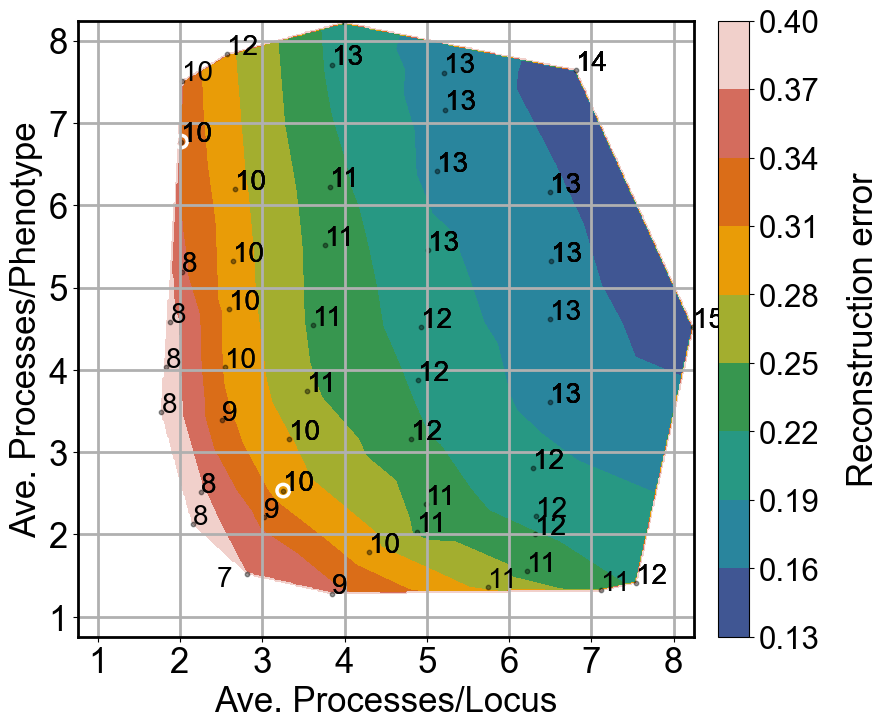

In [17]:
scatter = True
ve = .25
minx = 1-ve
maxx = 8+ve
miny = 1-ve
maxy = 8+ve
vmax = 0.40
vmin = 0.13

kpts = []
for i in np.arange(2.0,8,.5):
    for j in np.arange(1.5,8,.5):
        if i==2:
            if j in [1.5,2,3,6]:
                continue
        if j<2 and i==3: continue
        kpts.append((i,j))

cps = [(2,6.7),(3.2,2.5)]
kpts += cps

plot_solution_space(fct, K, lamb1_range, lamb2_range,  minx, maxx, miny, maxy, vmax, vmin, fs = 25,scatter=True, scatter_restricted=False, restrict_in_range = True, k_labeled_points = kpts, circled_points = cps,  save_name = fig_path + "sols_" + mode + ".pdf")


In [18]:
p210 = fct.find_key(2,6.7)
p310 = fct.find_key(3.2,2.5)

psvd = ('svd',10, None, (0,0))
params = [p210,p310,psvd]
name = {}
name[p210]= "2, 6.8 out of 10"
name[p310]= "3.2, 2.5 out of 10"
name[psvd]= "10 component SVD"

## Sorting environments and labeling loci

In [19]:
def make_linkage(W, plot = False):
    Mp = W[W.sum(axis = -1)!=0] # drop dropped loci

    pw = 1- np.abs(1- np.nan_to_num(scipy.spatial.distance.pdist(W, metric = "cosine"), nan = 0.0))
    if plot:
        plt.hist(pw.flatten());
        plt.xlabel("cos of pair")
        plt.ylabel("count")
        plt.show()

    return sc.hierarchy.linkage(pw, method = 'average')
    

In [20]:
linkage = make_linkage(F)

df = pd.DataFrame(F.T, columns = fct.env_names)
df=df.set_index(meta["Name"])
df["Annotation"] = [str(x) for x in meta["Literature_Pathway"]]
df.replace(
    to_replace='OTHER', 
    value='nan', inplace = True)
asort = np.argsort([str(x) for x in df["Annotation"]])
df.sort_values(by=['Annotation'], inplace=True)


In [21]:
color = {}
clist = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink","tab:cyan"]
for i,pname in enumerate(pathway_names[:-2]):
    color[pname]=clist[i]

In [22]:
print(color)

{'FORK QC': 'tab:blue', 'HR': 'tab:orange', 'FA/ICL repair': 'tab:green', 'EJ': 'tab:red', 'NER': 'tab:purple', 'MMR': 'tab:brown', 'RER': 'tab:pink', 'BER/SSBR': 'tab:cyan'}


In [23]:
row_colors = []
for i in range(len(df["Annotation"])):
    anno = df["Annotation"][i].split(";")[0]
    if anno in pathway_names[:-2]:
        row_colors.append(color[anno])
        #print(color[anno],anno)
    else:
        #print(len(row_colors), anno)
        row_colors.append("black")
        

In [24]:
wsort= sc.hierarchy.leaves_list(linkage)

## Compare solutions

In [25]:
fct_F = fct
fct_F.svd(10)

In [26]:
print("\tsolution\tam/L\tam/E\tnorm_err err")

for p in params:
    print(f"{name[p]}\t{em.ave_mod_per_loci(fct.M_preds[p]):.2f}\t{em.ave_mod_per_env(fct.W_preds[p]):.2f}\t{np.mean(fct.L2FFs[p]):.2f}\t{np.mean(fct.L2FTs[p]):.2f}")
print(f"           webster\t{em.ave_mod_per_loci(oM):.2f}\t{em.ave_mod_per_env(oW):.2f}\tN/A\t{np.mean(np.mean(np.square(F - oW@oM), axis = -1)):.2f}")

	solution	am/L	am/E	norm_err err


NameError: name 'em' is not defined

In [ ]:
for p in params:
    print(name[p], em.grassmann(fct.M_preds[p], oM), em.grassmann(fct.M_preds[psvd], fct.M_preds[p]))

In [ ]:
fs=18
shapes = ['o','s','^']
colors = clist + ["tab:gray", "tab:olive", 'black']
mn = 0
mx = 7
aname = {}
aname[p310]= "Selected SSD solution"
aname[p210]= "2 mod / locus SSD solution"
aname[psvd]= "10 component SVD solution"
plt.rc('font', size=18)
for p in params:
    print(name[p])
    #plot_and_print_W_M(fct, p, to_print = False, pp=100)
    EX = np.mean(np.square(F - oW@oM), axis = -1)[wsort]
    EY = fct_F.L2FTs[p][wsort]
    E = 31
    legend_labels = np.array(fct_F.env_names)[wsort]
    fig,axis = plt.subplots(1,1,figsize = (4,4))
    axis.tick_params(labelsize = fs)
    axis.ticklabel_format(useOffset = False,style='sci', scilimits = (-2,2))  
    #mn = min(np.min(EX), np.min(EY))
    #mx = max(np.max(EX), np.max(EY))
    #buf = (mx - mn) * .1
    #mn -= buf
    #mx += buf
    for _ in range(len(EX)):
        if _ >= 21: z = _+1
        else: z = _
        axis.plot(EX[_],EY[_],'o', label= legend_labels[_], ms = 7, color = colors[z%11], marker = shapes[int(z/11)])
    
    axis.plot([mn, mx],[mn,mx], 'C3--')
    axis.set_xlim(mn,mx)
    axis.set_ylim(mn,mx)
    axis.set_xticks(np.arange(1,int(mx)+1,1))
    axis.set_yticks(np.arange(1,int(mx)+1,1))
    axis.grid()
    #axis.set_xlabel("Webster", fontsize = fs)
    #axis.set_ylabel(aname[p], fontsize = fs)  
    if E < 100:     
        axis.legend(fontsize= fs,bbox_to_anchor=(1.05, 1.0), ncol = int(np.ceil(E/11)), frameon = False)
    for sp in ['top','bottom','left','right']:
        axis.spines[sp].set_linewidth(1.0)
    #axis.set_title("Reconstruction error by genotoxin", fontsize = fs)
    axis.set_xticklabels([])
    axis.set_yticklabels([])
    plt.show()
    fig.savefig(f"{fig_path}/scatter_{name[p]}.svg")

In [ ]:
#plot_and_print_W_M(fct, p, to_print = False, pp=100)
EX = np.mean(np.square(F - oW@oM), axis = -1)[wsort]
EY = EX
E = 31
legend_labels = np.array(fct_F.env_names)[wsort]
fig,axis = plt.subplots(1,1,figsize = (4,4))
axis.tick_params(labelsize = fs)
axis.ticklabel_format(useOffset = False,style='sci', scilimits = (-2,2))  
#mn = min(np.min(EX), np.min(EY))
#mx = max(np.max(EX), np.max(EY))
#buf = (mx - mn) * .1
#mn -= buf
#mx += buf
for _ in range(len(EX)):
    if _ >= 21: z = _+1
    else: z = _
    axis.plot(EX[_],EY[_],'o', label= legend_labels[_], ms = 7, color = colors[z%11], marker = shapes[int(z/11)])

axis.plot([mn, mx],[mn,mx], 'C3--')
axis.set_xlim(mn,mx)
axis.set_ylim(mn,mx)
axis.set_xticks(np.arange(1,int(mx)+1,1))
axis.set_yticks(np.arange(1,int(mx)+1,1))
axis.grid()
#axis.set_xlabel("Webster", fontsize = fs)
#axis.set_ylabel(aname[p], fontsize = fs)  
if E < 100:     
    axis.legend(fontsize= fs,bbox_to_anchor=(1.05, 1.0), ncol = int(np.ceil(E/11)), frameon = False)
for sp in ['top','bottom','left','right']:
    axis.spines[sp].set_linewidth(1.0)
#axis.set_title("Reconstruction error by genotoxin", fontsize = fs)
axis.set_xticklabels([])
axis.set_yticklabels([])
plt.show()
fig.savefig(f"{fig_path}/scatter_webster.svg")

In [ ]:
for p in params:
    print(name[p])
    display_modularity(fct, p, save_name = f"{fig_path}/loci_hist_{name[p]}.svg", nbins = 11, density = True, labels= False, figsize = (3,4))

## Plot F

In [27]:
sns.set(font="Arial")
sns.axes_style({'axes.spines.left': True, 'axes.spines.right': True})

{'axes.spines.left': True, 'axes.spines.right': True}

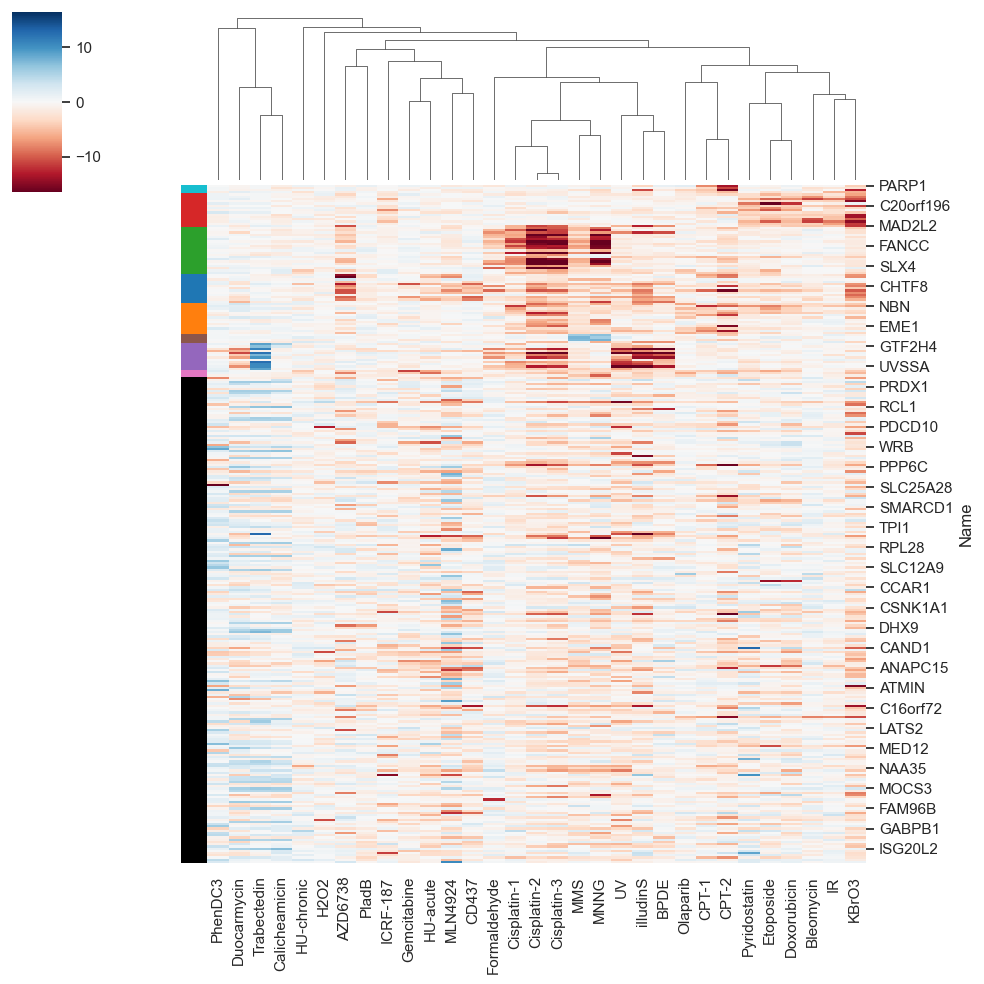

In [28]:
mm=np.max(np.abs(F))*0.6
x = sns.clustermap(df, row_cluster = False,row_colors= row_colors, col_linkage = linkage, vmin= -mm, vmax = mm, cmap = "RdBu", square = True)

x.savefig(f"{fig_path}/F_genotoxin.svg")  

### Plot W matrices

2, 6.8 out of 10


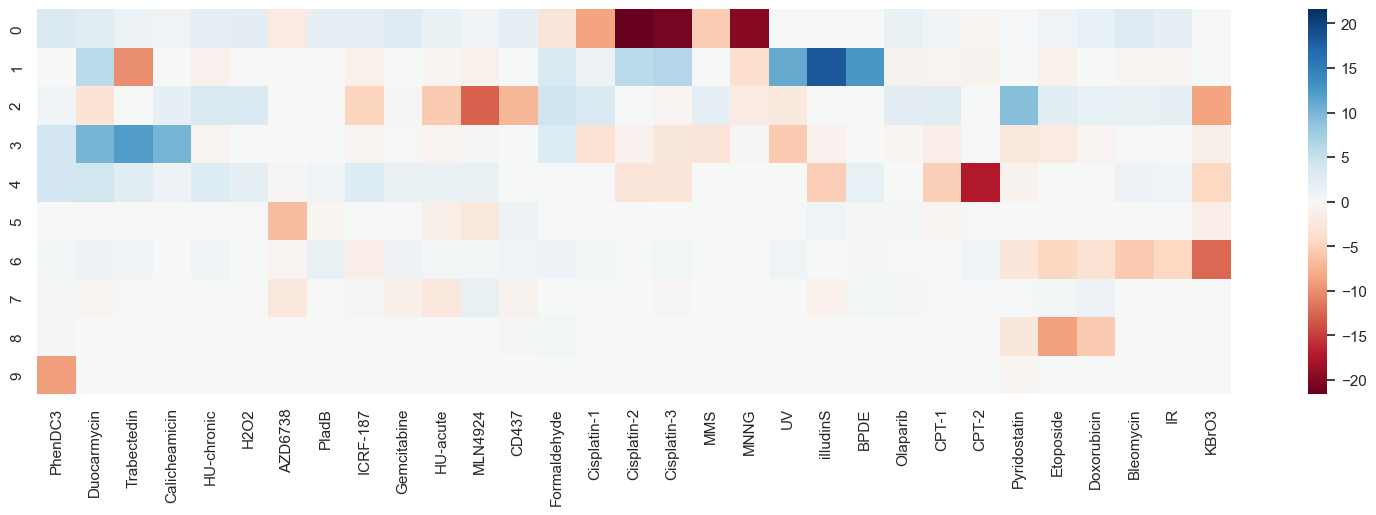

3.2, 2.5 out of 10


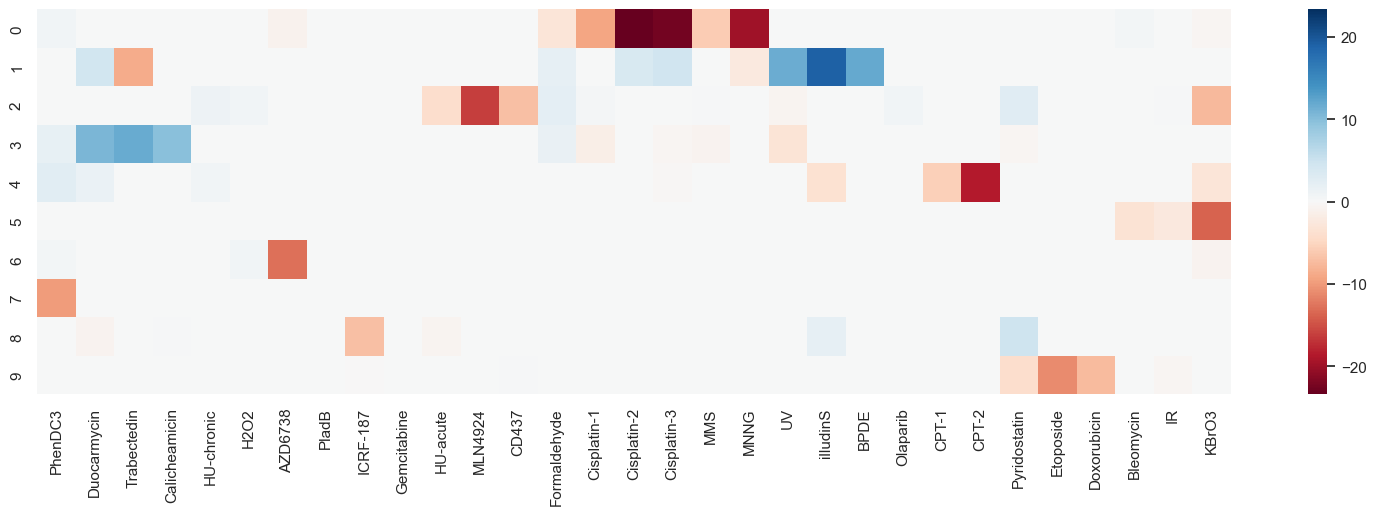

10 component SVD


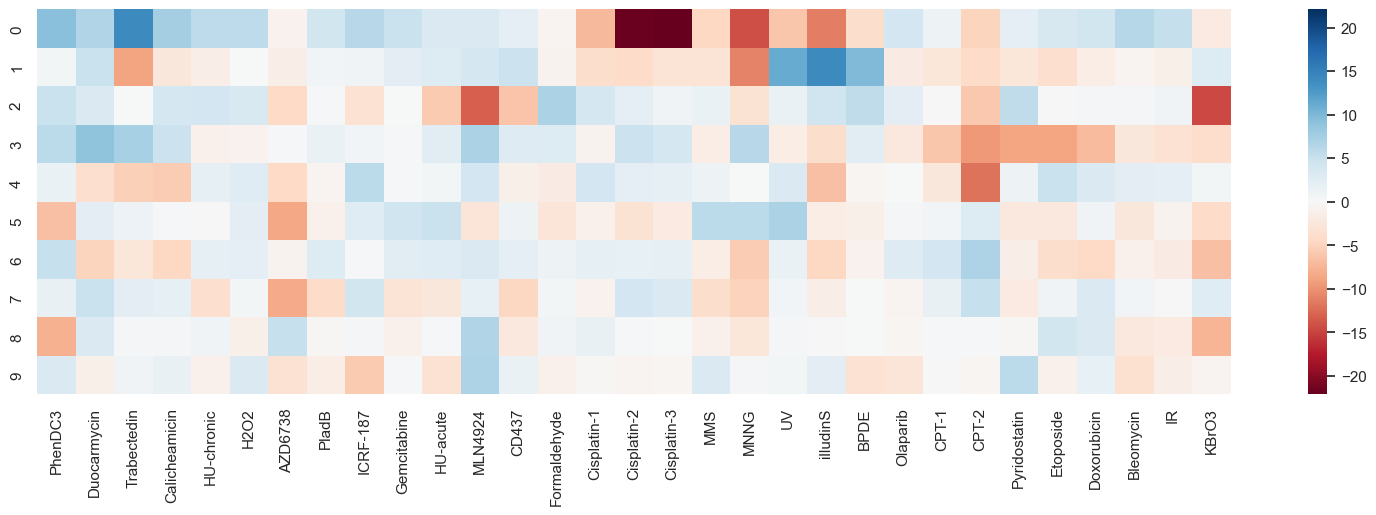

webster


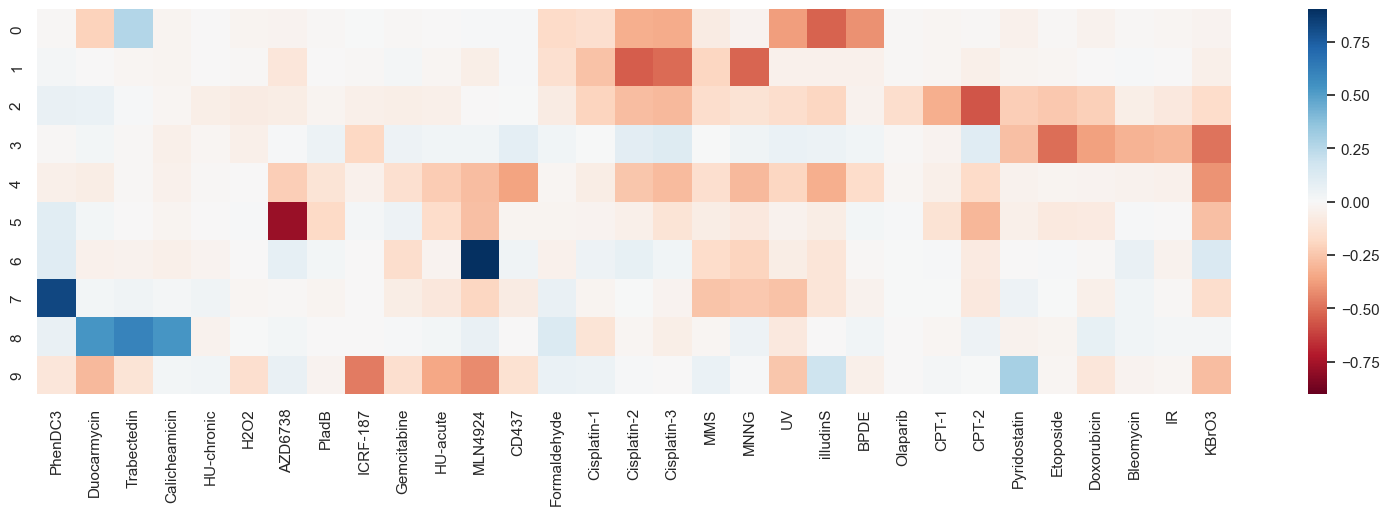

In [29]:
#p_link = psvd
#linkage = make_linkage(cut_zero_mods(fct_F.M_preds[p_link], fct_F.W_preds[p_link])[1])
for p in params:
    print(name[p])
    plt.figure(figsize = (20,5))
    W = cut_zero_mods(fct_F.M_preds[p], fct_F.W_preds[p])[1][wsort]
    mm = np.max(np.abs(W))
    x=sns.heatmap(pd.DataFrame(W.T, columns = np.array(fct.env_names)[wsort]), vmin= -mm, vmax = mm, cmap = "RdBu", square = True)
    x=x.get_figure()
    x.savefig(f"{fig_path}/W_{name[p]}.svg")  
    plt.show()
print("webster")
W = oW[wsort]
mm = np.max(np.abs(W))
plt.figure(figsize = (20,5))
x = sns.heatmap(pd.DataFrame(W.T, columns = np.array(fct.env_names)[wsort]), vmin= -mm, vmax = mm, cmap = "RdBu", square = True)
x=x.get_figure()
x.savefig(f"{fig_path}/W_webster.svg")  
plt.show()

### Plot Ms for our SSD solution

In [30]:
# printout top loci
p = p310
M = cut_zero_mods(fct_F.M_preds[p], fct_F.W_preds[p])[0]
lnames = list(od.columns)
mod, loci =  np.where(np.abs(M)>.25)
for i in range(len(mod)):
    print(mod[i],lnames[loci[i]] )

0 C17orf70
0 FANCA
1 ERCC5
1 ERCC8
1 GTF2H5
1 STK19
1 UVSSA
2 ANKRD49
2 CAND1
2 FKBPL
2 UBA3
4 CYB5R4
4 PARP1
4 PPP2R4
4 XRCC1
5 CTC-534A2.2
5 DCLRE1C
5 LIG4
5 NHEJ1
5 RNF168
6 LCMT1
6 POLE3
6 POLE4
6 RAD1
7 SLC18B1
8 CUL3
8 KCTD10
8 NF2
9 ABCC1
9 AMBRA1
9 ZNF451


3.2, 2.5 out of 10


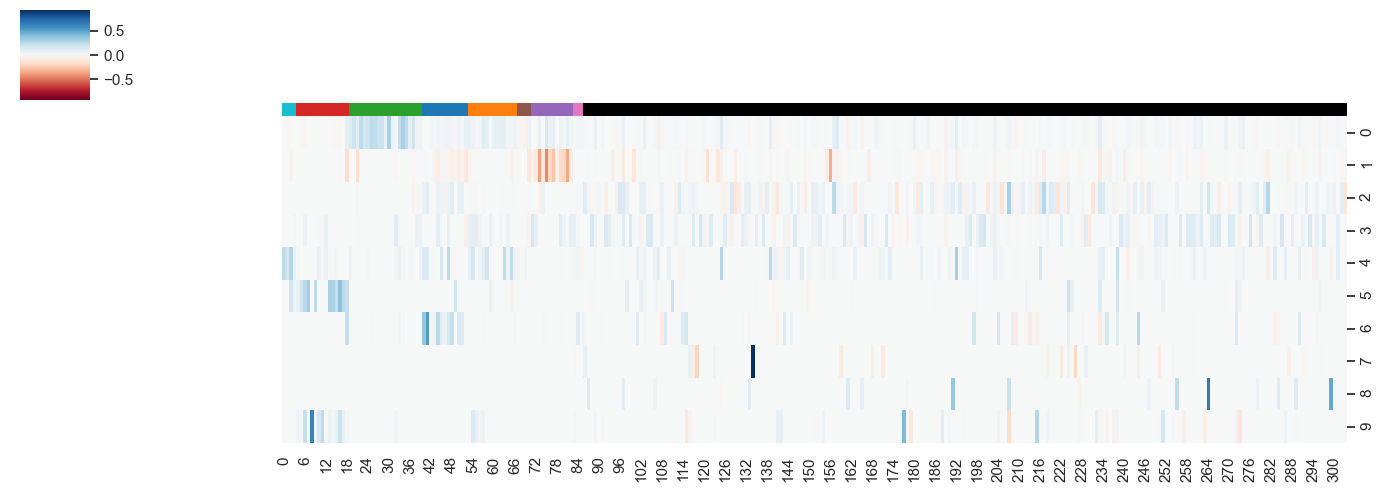

<Figure size 1000x300 with 0 Axes>

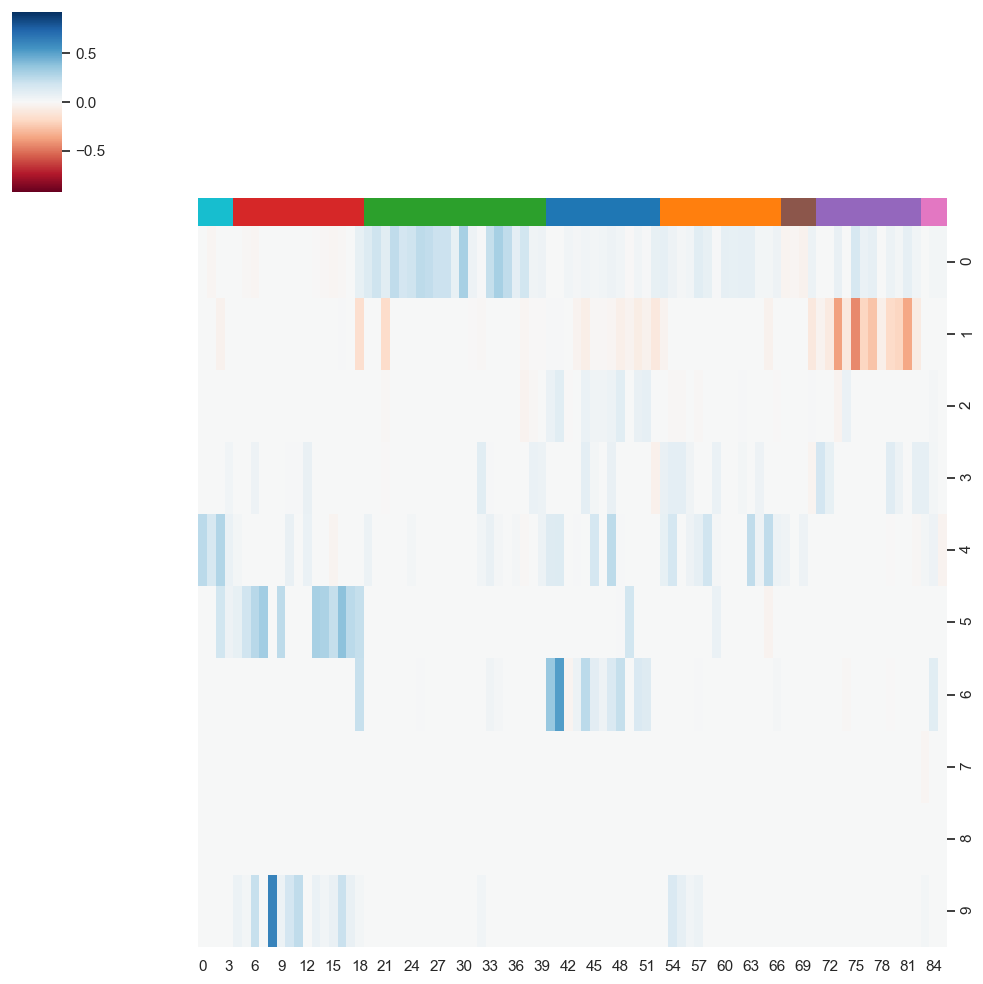

In [31]:
t = oM.shape[-1]
for p in [p310]:
    print(name[p])
    M = cut_zero_mods(fct_F.M_preds[p], fct_F.W_preds[p])[0][:,asort][:,:t]
    mm = np.max(np.abs(M))
    
    x=sns.clustermap(pd.DataFrame(M), figsize = (14,5), col_colors = row_colors[:t], row_cluster = False, col_cluster= False, vmin= -mm, vmax = mm, cmap = "RdBu")
    x.savefig(f"{fig_path}/our_M.svg")  
    t = 86
    M = cut_zero_mods(fct_F.M_preds[p], fct_F.W_preds[p])[0][:,asort][:,:t]
    plt.figure(figsize = (10,3))
    x=sns.clustermap(pd.DataFrame(M), col_colors = row_colors[:t], row_cluster = False, col_cluster= False, vmin= -mm, vmax = mm, cmap = "RdBu")
    x.savefig(f"{fig_path}/our_M_truncated.svg")  


In [32]:
#t = oM.shape[-1]
#for p in params:
#    print(name[p])
#    M = cut_zero_mods(fct_F.M_preds[p], fct_F.W_preds[p])[0][:,asort][:,:t]
#    mm = np.max(np.abs(M))
#    plt.figure(figsize = (10,3))
#    sns.clustermap(pd.DataFrame(M), col_colors = row_colors[:t], row_cluster = False, col_cluster= False, vmin= -mm, vmax = mm, cmap = "RdBu")
#print("webster")
#M = oM[:,asort][:,:t]
#mm = np.max(np.abs(M))
#sns.clustermap(pd.DataFrame(M), col_colors = row_colors[:t], row_cluster = False, col_cluster=False, vmin= -mm, vmax = mm, cmap = "RdBu")

In [33]:
#t = 86
#for p in params:
#    print(name[p])
#    M = cut_zero_mods(fct_F.M_preds[p], fct_F.W_preds[p])[0][:,asort][:,:t]
#    mm = np.max(np.abs(M))
#    sns.clustermap(pd.DataFrame(M), col_colors = row_colors[:t], row_cluster = False, col_cluster= False, vmin= -mm, vmax = mm, cmap = "RdBu", square = True)
#print("webster")
#M = oM[:,asort][:,:t]
#mm = np.max(np.abs(M))
#sns.clustermap(pd.DataFrame(M), col_colors = row_colors[:t], row_cluster = False, col_cluster=False, vmin= -mm, vmax = mm, cmap = "RdBu", square = True)